In [72]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
smiles = open('1to6.dmu.smi', 'r').read().splitlines()   # 6 heavy atoms only
print(len(smiles))
assert len(smiles) == len(set(smiles)), "Remove duplicates!" # check for duplicates
smiles[:10]

35466


['C', 'N', 'O', 'C#C', 'C#N', 'N#N', 'C=C', 'C=N', 'C=O', 'N=N']

In [73]:
tokens = sorted(set(''.join(smiles)))
stoi = {ch:i+1 for i,ch in enumerate(tokens)}    # character to index
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}  # index to character

In [74]:
stoi

{'#': 1,
 '(': 2,
 ')': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '=': 9,
 'C': 10,
 'N': 11,
 'O': 12,
 '.': 0}

In [75]:
import numpy as np
N = np.zeros((len(stoi), len(stoi)), dtype=np.int32)
for s in smiles:
    chs = ['.'] + list(s) + ['.']
    for ch1,ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [76]:
N.shape

(13, 13)

(-0.5, 12.5, 12.5, -0.5)

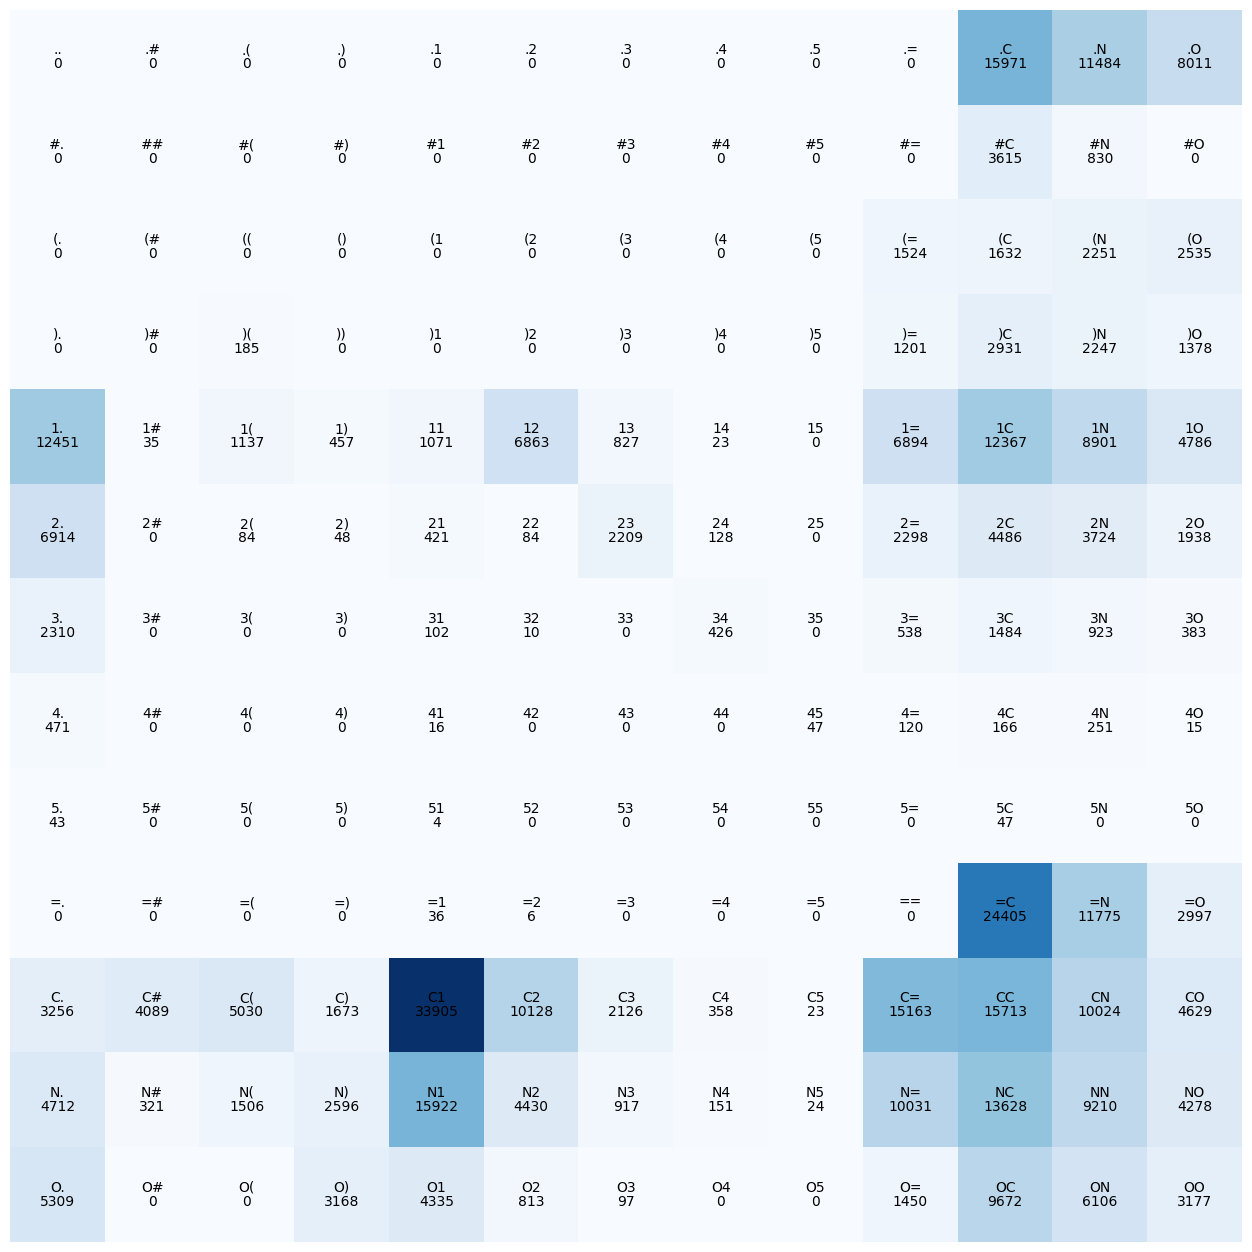

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(N, cmap='Blues')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='k')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='k')
plt.axis('off')

In [78]:
import random
import torch 

def build_dataset(smiles: list, context_length: int = 3):
    X, Y = [], []
    context_len = context_length   # How mnay characters to consider before predicting the next one
    
    for sml in smiles:
        context = [0] * context_len
        for ch in sml + '.':
            Y.append(stoi[ch])
            X.append(context)
            context = context[1:] + [stoi[ch]]   # Crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y) 
    print('X.shape: ', X.shape, 'Y.shape: ', Y.shape)            
    return X, Y

int1 = int(len(smiles)*0.8)
int2 = int(len(smiles)*0.9)     

context_len = 3
random.shuffle(smiles)
Xtr, Ytr = build_dataset(smiles[:int1], context_length=context_len)
Xdev, Ydev = build_dataset(smiles[int1:int2], context_length=context_len)
Xtest, Ytest = build_dataset(smiles[int2:], context_length=context_len) 


X.shape:  torch.Size([310665, 3]) Y.shape:  torch.Size([310665])
X.shape:  torch.Size([38971, 3]) Y.shape:  torch.Size([38971])
X.shape:  torch.Size([38850, 3]) Y.shape:  torch.Size([38850])


In [81]:
# Set up model, using the notation from Bengio et al. 2003 "A Neural Probabilistic Language Model"
n_dim = 2
C = torch.randn((len(stoi), n_dim))   # 2-dim embedding, look up table
H = torch.rand(context_len*n_dim, 100)
d = torch.rand(100) 
U = torch.rand(100, len(stoi))
b = torch.rand(len(stoi))

parameters = [C, H, d, U, b]

for p in parameters:
    p.requires_grad = True  

In [101]:
import torch.nn.functional as F
# Run the model
for _ in range(1000):
    # Create mini-batch
    idx = torch.randint(len(Xtr), (100,))  # 100 random indices
    emb = C[Xtr[idx]]  # select the embeddings
    Ybatch = Ytr[idx]  # select the targets
    
    # Forward pass
    h1 = torch.tanh(emb.view(-1,context_len*n_dim) @ H + d)
    logits = h1 @ U + b
    loss = F.cross_entropy(logits, Ybatch)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update weights
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad.data
print(loss.item())   
        

1.4463050365447998


In [102]:
# print train error 
emb = C[Xtr]
h1 = torch.tanh(emb.view(-1, context_len*n_dim) @ H + d)
logits = h1 @ U + b
loss = F.cross_entropy(logits, Ytr)
loss.item()

1.5329338312149048

In [103]:
# print dev error 
emb = C[Xdev]
h1 = torch.tanh(emb.view(-1, context_len*n_dim) @ H + d)
logits = h1 @ U + b
loss = F.cross_entropy(logits, Ydev)
loss.item()

1.5320651531219482

In [107]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * context_len
    while True:
        emb  = C[torch.tensor([context])] 
        h1 = torch.tanh(emb.view(1, -1) @ H + d) 
        logits = h1 @ U + b 
        probs = F.softmax(logits, 1) 
        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

CNCO)N=C1O.
C1=O.
CC12.
NN1C=C=NN1CN4(.
NC1NN1N1.
CC1.
1=NN1CNC1=O.
CC1(O)C#C1C41N23.
C1C=NN12.
CN1CC=C1NO.
NC1N=C1CC12.
N=CN12.
CN(CN)N=C1C#COC1NNNNC1=C2O)N1.
N1N2CN1(.
OC1=C1.
C1CNCOC3N1C1=CNO1.
C1C2N)C(N)=N3C13.
NO.
NC1=NC1=NC1=CC=C#C1=O1N=CN1.
C=C1.


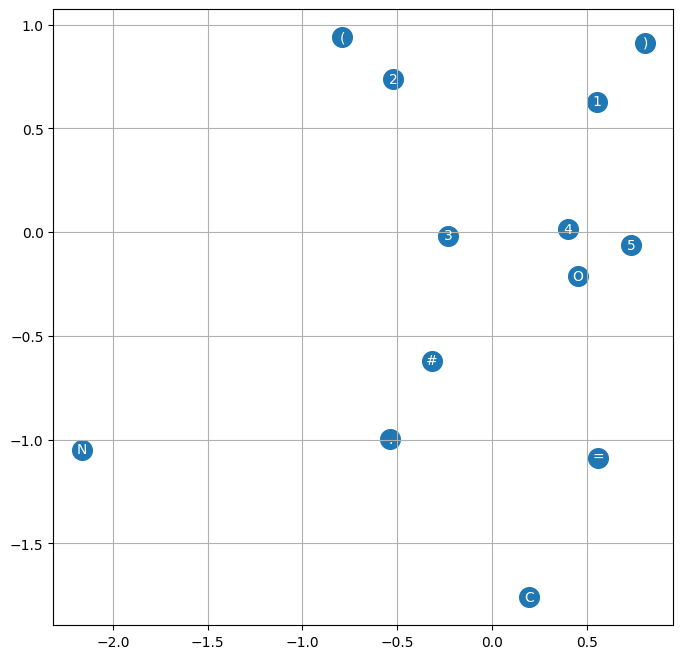

In [108]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white', fontsize=10)
plt.grid('minor')